In [1]:
import pandas as pd
import numpy as np

# Carregando datasets

In [2]:
dataretrieve = pd.read_csv("..//datasets/dataretrieve.csv", na_values='?')
desharnais = pd.read_csv("..//datasets/desharnais.csv", na_values='?')
dataretrieve = dataretrieve.fillna(0)
desharnais = desharnais.fillna(0)

In [3]:
with open("..//datasets/dataretrieve.txt") as infile:
    dataretrievelist = infile.read()
    dataretrievelist = dataretrievelist.split(',')
with open("..//datasets/desharnais.txt") as infile:
    desharnaislist = infile.read()
    desharnaislist = desharnaislist.split(',')

# PCA

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
def myPCA(dataset, components):
    #A última coluna é a classe
    dataX = dataset.loc[:,dataset.columns[:-1]].values
    dataY = dataset.loc[:,[dataset.columns[-1]]].values
    
    dataXstd = StandardScaler().fit_transform(dataX)
    
    covMat = np.cov(dataXstd.T)
    
    eigVals, eigVecs = np.linalg.eig(covMat)
    
    eigPairs = [(np.abs(eigVals[i]), eigVecs[:,i]) for i in range(len(eigVals))]
    
    totalInfo = sum(eigVals)
    infoCovered = [(i / totalInfo) for i in sorted(eigVals, reverse=True)]
    cumInfoCovered = np.cumsum(infoCovered)
    
    pos = 0
    if(components == 0):
        for i in range(len(cumInfoCovered)):
            if(i==len(cumInfoCovered)-1):
                pos = i-1
                break
            if (cumInfoCovered[i] > 0.9):
                pos = i
                break
    else:
        pos = components - 1
    
    matrixW = np.hstack((eigPairs[0][1].reshape(len(eigVals),1)))
    
    for j in range(1, pos+1):
        matrixW = np.c_[matrixW, eigPairs[j][1].reshape(len(eigVals),1)]
        
    transformedData = dataXstd.dot(matrixW)
    
    return transformedData, matrixW

# Knn x Nº de Componentes

In [6]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [7]:
def calcScores(dataset):
    knn = KNeighborsClassifier(n_neighbors=3)
    dataY = dataset.loc[:,[dataset.columns[-1]]].values.ravel()
    #c, r = dataY.shape
    #dataY = dataY.reshape(c,)
    scores = []
    pcs = []
    for i in range(1,len(dataset.columns)):
        transformedData, matrixW = myPCA(dataset, i)
        if(i==1):
            transformedData = transformedData.reshape((transformedData.shape[0],1))
        compScores = cross_val_score(knn, transformedData, dataY, cv=5, scoring='accuracy')
        scores.append(np.mean(compScores))
        pcs.append(i)
    return scores, pcs

# Resultados

In [8]:
#Warning por conta da conversão dos valores do dataset para dados normalizados
dataretrieveScores, dataretrievePcs = calcScores(dataretrieve)
desharnaisScores, desharnaisPcs = calcScores(desharnais)

/Users/ajgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/ajgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/ajgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/ajgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/ajgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Da

In [9]:
dataretrieveScores

[0.90793162393162397,
 0.90793162393162397,
 0.88393162393162394,
 0.88393162393162394,
 0.88393162393162394,
 0.89962393162393162,
 0.89962393162393162,
 0.89962393162393162]

In [10]:
desharnaisScores

[0.43382352941176466,
 0.51764705882352946,
 0.53014705882352942,
 0.60514705882352948,
 0.59264705882352942,
 0.58014705882352946,
 0.58014705882352946,
 0.55514705882352944,
 0.55514705882352944,
 0.55514705882352944,
 0.55514705882352944]

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

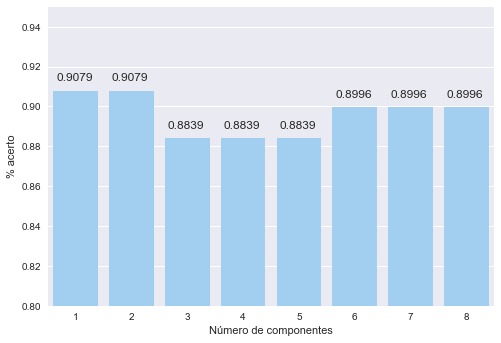

In [12]:
plt.ylim((0.80,0.95))
ax = sns.barplot(x=dataretrievePcs, y=dataretrieveScores, color = sns.xkcd_rgb['light blue'])
ax.set(xlabel='Número de componentes')
ax.set(ylabel='% acerto')
for p in ax.patches:
    ax.annotate(np.round(p.get_height(), decimals=4), (p.get_x()+0.05, p.get_height()+0.005))
plt.savefig("..//results/dataretrievePCA.jpg")
plt.show()

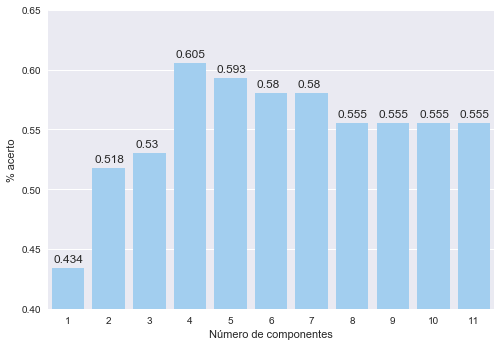

In [13]:
plt.ylim((0.40,0.65))
ax = sns.barplot(x=desharnaisPcs, y=desharnaisScores, color = sns.xkcd_rgb['light blue'])
ax.set(xlabel='Número de componentes')
ax.set(ylabel='% acerto')
for p in ax.patches:
    ax.annotate(np.round(p.get_height(), decimals=3), (p.get_x()+0.05, p.get_height()+0.005))
plt.savefig("..//results/dataretrievePCA.jpg")
plt.show()

# LDA

In [145]:
def myLDA(dataset):
    
    classList = dataset[dataset.columns[-1]].unique()
    classCount = len(classList)
    
    dataX = dataset.loc[:,dataset.columns[:-1]].values
    dataY = dataset.loc[:,[dataset.columns[-1]]].values
    
    dataXstd = StandardScaler().fit_transform(dataX)

    meanVectors = []
    for i in range(classCount):
        myList = []
        for j in range(len(dataY)):
            if ((dataY==classList[i])[j] == True):
                myList.append(j)
        meanVectors.append(np.mean(dataXstd[myList], axis=0))
    print(meanVectors)

myLDA(desharnais)

[array([-0.3821,  0.0856, -0.1825, -0.2924, -0.0087,  0.1577, -0.0416,
       -0.0125, -0.0391,  0.2314, -0.003 ]), array([ 0.515 , -0.0956,  0.1741,  0.3242,  0.0767,  0.016 , -0.1375,
        0.1743, -0.0273, -0.398 , -0.0785]), array([ 0.4705, -0.1545,  0.4044,  0.5346, -0.1518, -0.7655,  0.535 ,
       -0.3786,  0.2479, -0.0693,  0.2101])]
